# Processing data
Purpose of this workbook is, given a super folder (which holds .csv files of interest), go through and allow filtering based on tag (using regex)

Then, can take specific subsets of this data to then plot together and allow comparison.

In [22]:
# Import Cell
import sys
sys.path.append('..')
from Utility import process_data_utils as pdu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import os
from scipy.optimize import curve_fit

In [23]:
# Read in processed csvs
path_sam = "../ProcessedData/2023_11_Organized_Images_SAM_total.csv"
path_ensemble = "../ProcessedData/2023_11_Organized_Images_ensemble_total.csv"

df_sam = pd.read_csv(path_sam)
df_ensemble = pd.read_csv(path_ensemble)

df_master = df_sam


/var/folders/vk/znvr66h543g3tt_w4mwmsslh0000gn/T/ipykernel_76856/61347122.py:5: DtypeWarning: Columns (2,3,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sam = pd.read_csv(path_sam)
/var/folders/vk/znvr66h543g3tt_w4mwmsslh0000gn/T/ipykernel_76856/61347122.py:6: DtypeWarning: Columns (2,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ensemble = pd.read_csv(path_ensemble)


In [24]:
## Set columns where relevant

In [25]:
# Define which parameters you want to set as constant
# Leave out lines you want varied by commenting

sub_df = df_master[
        (df_master.L == 4) &
    #    (df_master.concentration == 2.5) &
        (df_master.mixing == "F") &
        (df_master.oven == "F")
        ]
exp_list = np.unique(sub_df.search_str)
num_exp = len(exp_list)
cm_arr = cm.get_cmap('viridis',num_exp)
print(exp_list)


['L-4_nM-10_mixing-F_oven-F' 'L-4_nM-5_mixing-F_oven-F']


Crystal
88.0 1638
Multiple Crystal
88.0 284
Incomplete
88.0 1911
Crystal
88.0 1486
Multiple Crystal
88.0 25
Incomplete
88.0 2427


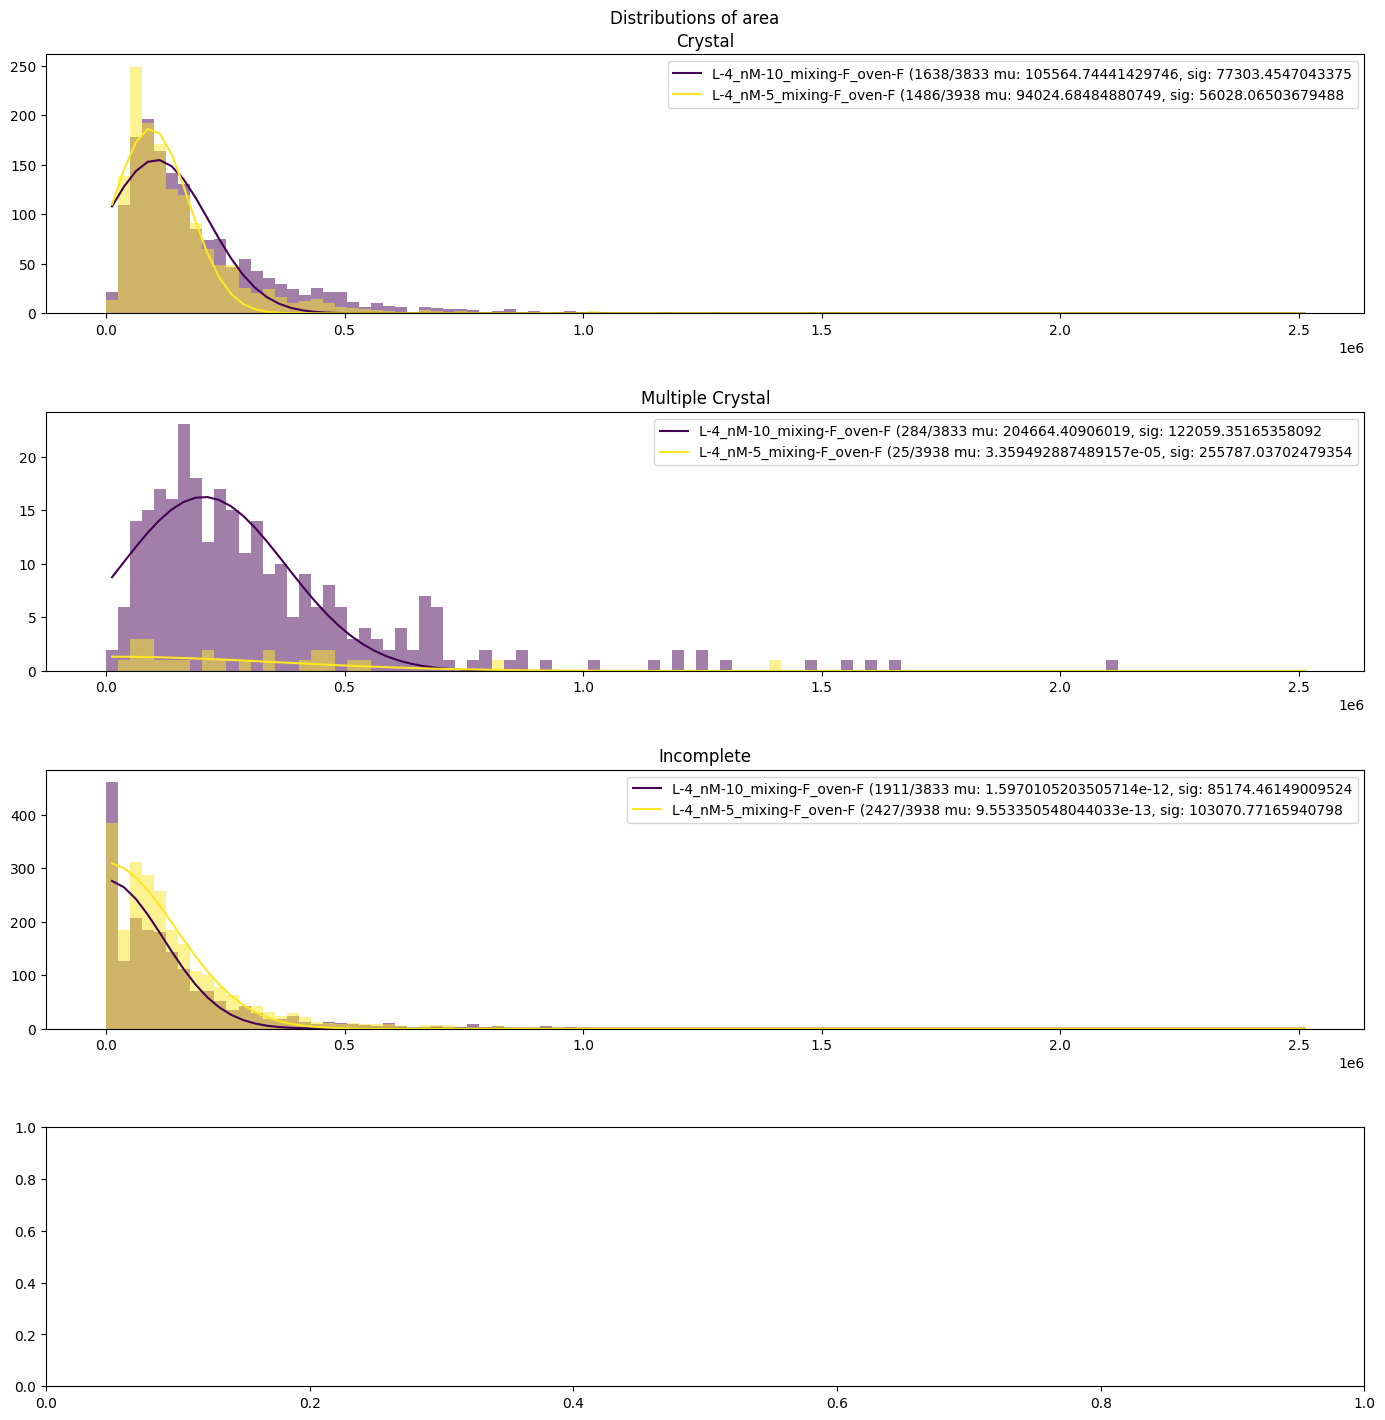

In [27]:
# Gaussian Cell
fig_gaussian = pdu.plot_feature_with_experiments_gaussian(df_master,'area',exp_list,color_list=cm_arr.colors)
plt.show(fig_gaussian)



In [28]:
# Schulz Cell
fig_sz = pdu.plot_feature_with_experiments_schultz_zimm('area',exp_list,color_list=cm_arr.colors)
plt.show(fig_sz)



FileNotFoundError: [Errno 2] No such file or directory: '../Results/L-4_nM-10_mixing-F_oven-F'

TypeError: schultz_zimm() takes 4 positional arguments but 5 were given

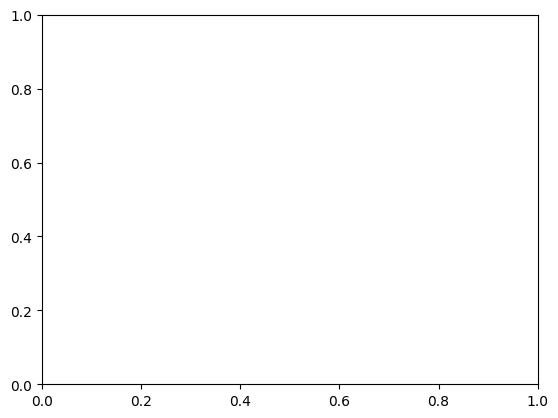

In [ ]:
## WIP cell for checking out what's going on with Schultz-Zimm
from scipy.optimize import curve_fit
sz = pdu.schultz_zimm
df_oi = pdu.load_dataframe(exp_list[0])
df_oi = df_oi[df_oi["Labels"] == "Crystal"]
fig_oi, ax_oi = plt.subplots()
# COPY PASTING CODE FROM pdu
feature = 'area'
max_out = 2.50*10**6 if feature == 'area' else 2000


histogram_min = df_oi[feature].min()
histogram_max = df_oi[feature].max()
histogram_bins = np.round(np.linspace(histogram_min, max_out,200))


freq = pdu.get_frequency(df_oi,histogram_bins,feature)
scale_factor = 1#counts*histogram_bins[0]
x_bins = histogram_bins #+ (histogram_bins[2]-histogram_bins[1])/2 # Fit to center of bin
prob = np.array(freq)/(np.sum(freq))
popt,pcov = curve_fit(sz,x_bins,prob,
                                  p0=[0,0,1],
                                  bounds=([0.0,0.0,0.5],[50,5,2.1]),
                                  )
a = popt[0]
b = popt[1]
molecular_weight = b/a
molecular_number = (b+1)/a
pdi = molecular_weight/molecular_number


ax_oi.plot(x_bins,sz(histogram_bins,*popt)*scale_factor/np.diff(histogram_bins)[0],color='r')

weights=df_oi[feature]/len(df_oi[feature])
ax_oi.hist(x=df_oi[feature],bins=histogram_bins,color='r',alpha=.5,density=True)
ax_oi.scatter(histogram_bins,prob/np.diff(histogram_bins)[0])

ax_oi.legend()


print(popt)
ax_oi.plot(x_bins,sz(histogram_bins,
                     *[7,.75,.5,1e4])*scale_factor/np.diff(histogram_bins)[0],
                     color='g')


In [ ]:
c1 = 

SyntaxError: invalid syntax (4246105365.py, line 1)